In [85]:
# Defining function to load gpx data into dataframe with some processing using the harvesine equation
import gpxpy
import pandas as pd
from haversine import haversine

def gpx_to_dataframe(file_name):
    """
    Parses a GPX file and returns a Pandas DataFrame with extracted data.
    
    Args:
        file_name (str): The path to the GPX file.
        
    Returns:
        pd.DataFrame: A DataFrame containing latitude, longitude, elevation, time,
                      and other optional GPX fields.
    """
    # Open and parse the GPX file
    with open(file_name, 'r') as gpx_file:
        gpx = gpxpy.parse(gpx_file)

    # Extract data from tracks (you can also extract waypoints, routes, etc.)
    data = []
    for track in gpx.tracks:
        for segment in track.segments:
            print('Points to read:',len(segment.points))
            for i, point in enumerate(segment.points):
                
                if i==0:
                    prev_point = point
                    dist_delta = 0
                    total_dist = 0
                else:
                    dist_delta = haversine(
                        (prev_point.latitude, prev_point.longitude),
                        (point.latitude, point.longitude)
                    )
                    # Overwriting prev_point for next iteration loop
                    prev_point = point 
                    total_dist = data[-1]['total_distance'] + dist_delta

                data.append({
                    'latitude': point.latitude,
                    'longitude': point.longitude,
                    'elevation': point.elevation,
                    'total_distance': total_dist,
                    'distance_delta': dist_delta
                })

    # Convert to DataFrame
    df = pd.DataFrame(data)
    df['grade'] = df['elevation'].diff()/df['distance_delta']/10
    df = df.fillna(0)

    return df

# Example usage:
# df = gpx_to_dataframe('your_file.gpx')
# print(df.head())


In [86]:
df = gpx_to_dataframe('gpx_files/2024-05-26_1608879815_Halbtraum_2024.gpx')
df

Points to read: 1467


,latitude,longitude,elevation,total_distance,distance_delta,grade
0,48.618020,9.838883,458.115216,0.000000,0.000000,0.000000
1,48.617972,9.838958,458.115216,0.007673,0.007673,0.000000
2,48.617922,9.839649,458.115216,0.058771,0.051098,0.000000
3,48.618065,9.840182,458.132978,0.101055,0.042284,0.042007
4,48.617321,9.841178,459.993274,0.211529,0.110474,1.683921
...,...,...,...,...,...,...
1462,48.619128,9.838277,463.316261,58.381339,0.005346,0.000000
1463,48.618907,9.838418,463.316261,58.408009,0.026670,0.000000
1464,48.618636,9.838593,463.316261,58.440774,0.032765,0.000000
1465,48.618471,9.838769,463.316261,58.463223,0.022450,0.000000


Text(0, 0.5, 'Grade')

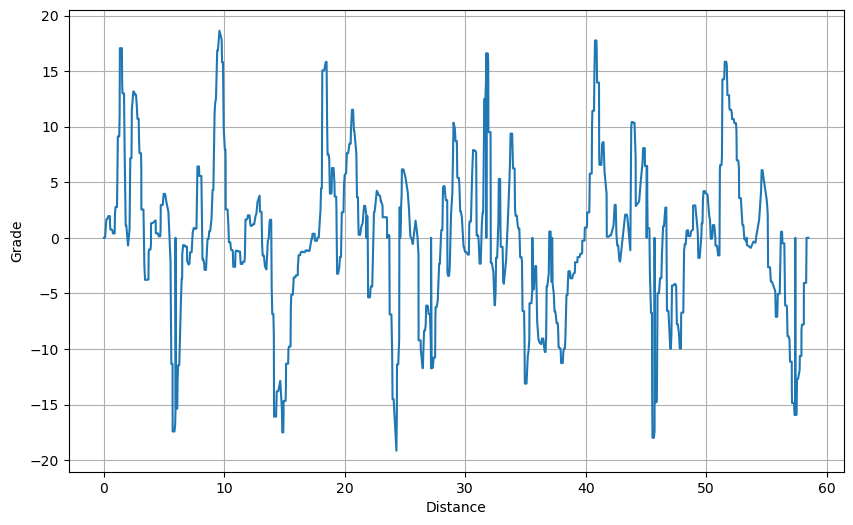

In [87]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(df.total_distance, df.grade)
plt.grid(True)
plt.xlabel('Distance')
plt.ylabel('Grade')